# Ford GoBike System Data

## by/  Ahmad Mostafa

## Investigation Overview

> * **Study of User Type Effect**
* **Study of Trip Distances**
* **Study of Trip Duration**

## Dataset Overview

> **2017-fordgobike-tripdata**, Each trip is anonymized and includes:
* Trip Duration (seconds)
* Start Time and Date
* End Time and Date
* Start Station ID
* Start Station Name
* Start Station Latitude
* Start Station Longitude
* End Station ID
* End Station Name
* End Station Latitude
* End Station Longitude
* Bike ID
* User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df= pd.read_csv('2017-fordgobike-tripdata.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber


In [3]:
# creating duration in minutes feature (more reliable)
df['duration_min'] = df['duration_sec'] / 60

# Converting start dates from string to datetime
df['start_time'] = pd.to_datetime(df['start_time'])

# get month
df['start_month'] = df['start_time'].dt.strftime('%B')
df['start_month'] = df['start_month'].astype('category')

# get weekday
df['week_day'] = df['start_time'].dt.strftime('%a')

df['week_day'] = df['week_day'].astype('category')

# get period
df['start_hour'] = df['start_time'].dt.hour
df['start_period'] = 'Morning'
df['start_period'][(df['start_hour'] >= 12) & (df['start_hour'] <= 17)] = 'Afternoon'
df['start_period'][(df['start_hour'] >= 18) & (df['start_hour'] <= 23)] = 'Night'

In [4]:
import math

def distance(origin, destination):
    """
    Calculate the Haversine distance.
    Parameters
    ----------
    origin : tuple of float(lat, long)
    destination : tuple of float(lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

df['distance_km'] = df.apply(lambda x:
                             distance((x['start_station_latitude'], x['start_station_longitude']),
                                      (x['end_station_latitude'], x['end_station_longitude'])),axis=1)

In [5]:
# Clean df
df_c = df.drop(columns=['duration_sec', 'start_time', 'end_time', 'start_station_latitude', 
                           'start_station_longitude', 'end_station_latitude','end_station_longitude',
                           'start_station_id', 'end_station_id','bike_id'])

# remove zero distance !
df_c = df_c.query("distance_km > 0")

## Effect of User Type 

> * **Subscribers (Members) are more active(about 80%) than Customers(Casual)(about 20%)**
* **Although Customers are casual users, they, in average, make longer trips (in duration) than Subscribers**


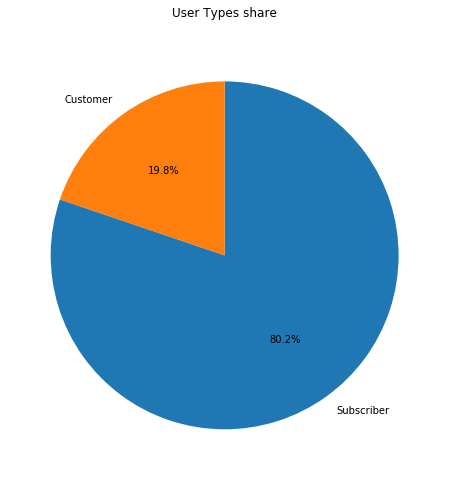

In [7]:
user_index = df_c['user_type'].value_counts().index

plt.figure(figsize = [8, 8]) 
plt.pie(df_c['user_type'].value_counts(),  labels = user_index,
        startangle = 90, counterclock = False, autopct='%1.1f%%');
plt.title('User Types share\n');

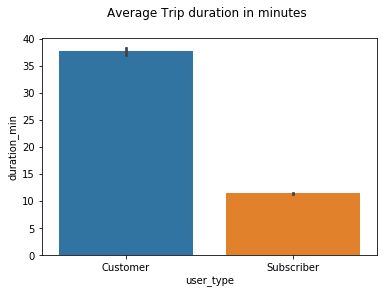

In [8]:
sb.barplot(x="user_type",y="duration_min", data=df_c);
plt.title('Average Trip duration in minutes \n');

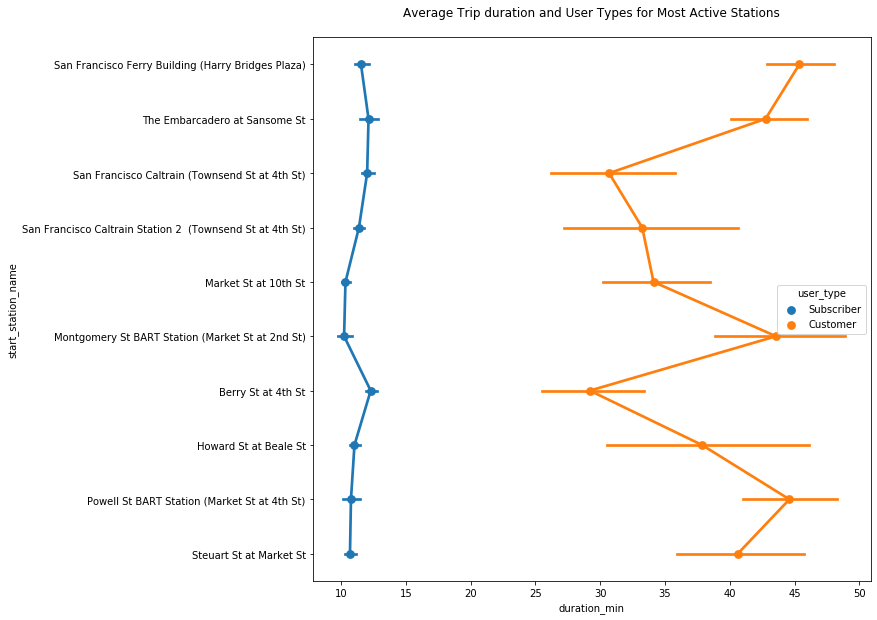

In [9]:
plt.figure(figsize = [10, 10])
sb.pointplot(data = df_c_top10st, y= 'start_station_name', 
             x = 'duration_min',hue ='user_type', order = top10st);
plt.title('Average Trip duration and User Types for Most Active Stations\n');

## Study of Trip Distances

> **Most trips used for distances less than 3 km, and the majority of them are between about 0.5 and 2 km**


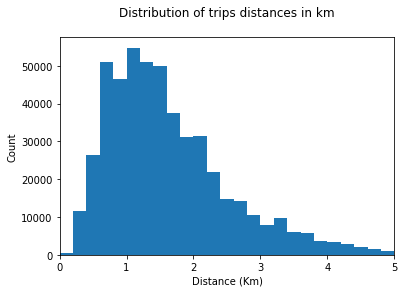

In [12]:
bins = np.arange(0, df_c['distance_km'].max()+0.1, 0.2)
plt.hist(df_c['distance_km'], bins = bins);
plt.xlim(0,5);
plt.title('Distribution of trips distances in km\n');
plt.xlabel('Distance (Km)');
plt.ylabel('Count');

## Study of Trip Duration

> **Most trips take less than 20 minutes, and the majority of them between aboyt 5 and 15 minutes**
* **Although Customers are casual users, they, in average, make longer trips than Subscribers**


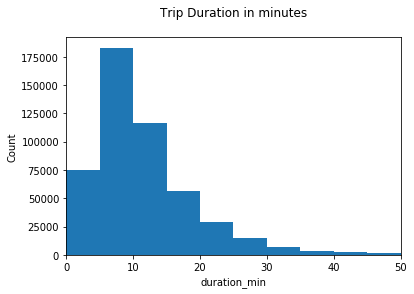

In [11]:
bins = np.arange(0, df_c['duration_min'].max()+5 , 5)
sb.distplot(df_c['duration_min'], kde= False, hist_kws= {'alpha': 1}, bins =bins);
plt.xlim(0,50);
plt.title('Trip Duration in minutes\n');
plt.ylabel('Count');

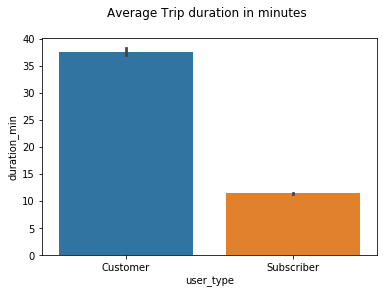

In [15]:
sb.barplot(x="user_type",y="duration_min", data=df_c);
plt.title('Average Trip duration in minutes \n');